In [1]:

# === Imports & reproducibility ===
import os, math, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as L, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mnv2_pre

In [2]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
AUTO = tf.data.AUTOTUNE

# === Hyperparams (tweak as needed) ===
IMAGE_SIZE = (224, 224)   # resize CIFAR-10 images
BATCH_SIZE = 256
NUM_CLASSES = 10

TEACHER_EPOCHS = 10
STUDENT_STAGE1_EPOCHS = 10  # distill from teacher1
STUDENT_STAGE2_EPOCHS = 10  # distill from teacher2

BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1


In [3]:
CKPT_DIR = "ckpts_sequential_kd"
os.makedirs(CKPT_DIR, exist_ok=True)

# === Load CIFAR-10 and build tf.data datasets ===

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# One-hot labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Train/val split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=np.argmax(y_train, axis=1)
)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
def preprocess_resize(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)  # leave actual model preprocessing to model builder
    return image, label

def make_ds(x, y, batch_size=BATCH_SIZE, augment=False, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(10000, seed=SEED)
    ds = ds.map(preprocess_resize, num_parallel_calls=AUTO)
    if augment:
        aug = tf.keras.Sequential([
            L.RandomFlip("horizontal"),
            L.RandomRotation(0.08),
            L.RandomZoom(0.08),
        ])
        ds = ds.map(lambda img, lbl: (aug(img), lbl), num_parallel_calls=AUTO)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

In [5]:
train_ds = make_ds(x_train, y_train, augment=False, shuffle=False)
val_ds   = make_ds(x_val, y_val, augment=False, shuffle=False)
test_ds  = make_ds(x_test, y_test, augment=False, shuffle=False)

# === Backbone builder with model-specific preprocessing ===
# Supports "mobilenetv2" and "efficientnetb0" (add more if you want)


# EfficientNet import (tf.keras.applications.efficientnet available in TF >= 2.6+)
try:
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre
except Exception as e:
    EfficientNetB0 = None
    eff_pre = None
    print("Warning: EfficientNetB0 not available in this TF build:", e)


In [6]:
def get_backbone(backbone_name: str, input_tensor):
    name = backbone_name.lower()
    if name == "mobilenetv2":
        # MobileNetV2 expects inputs scaled to [-1,1]
        x = L.Lambda(mnv2_pre, name=f"{name}_pre")(input_tensor)
        base = MobileNetV2(input_tensor=x, include_top=False, weights="imagenet")
        return base, base.output
    elif name == "efficientnetb0":
        if EfficientNetB0 is None:
            raise RuntimeError("EfficientNetB0 not available in this TF installation.")
        x = L.Lambda(eff_pre, name=f"{name}_pre")(input_tensor)
        base = EfficientNetB0(input_tensor=x, include_top=False, weights="imagenet")
        return base, base.output
    else:
        raise ValueError(f"Unsupported backbone: {backbone_name}")


In [7]:
def build_classifier(backbone_name: str, num_classes: int = NUM_CLASSES,
                     wd=WEIGHT_DECAY, dropout=0.3, input_shape=(*IMAGE_SIZE, 3)):
    inputs = L.Input(shape=input_shape)
    base, feats = get_backbone(backbone_name, inputs)
    x = L.GlobalAveragePooling2D()(feats)
    x = L.Dropout(dropout)(x)
    outputs = L.Dense(num_classes, kernel_regularizer=regularizers.l2(wd))(x)  # logits
    return Model(inputs, outputs, name=f"{backbone_name}_classifier")

In [8]:
def small_cnn(input_shape=(*IMAGE_SIZE, 3), num_classes=NUM_CLASSES, wd=1e-4):
    inputs = L.Input(shape=input_shape)
    x = inputs
    # Three conv blocks
    for filters in (32, 64, 128):
        x = L.Conv2D(filters, 3, padding="same", kernel_regularizer=regularizers.l2(wd))(x)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.MaxPool2D(2)(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(0.4)(x)
    outputs = L.Dense(num_classes, kernel_regularizer=regularizers.l2(wd))(x)  # logits
    return Model(inputs, outputs, name="small_cnn")

In [9]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher, temperature=4.0, alpha=0.5, label_smoothing=0.0):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = float(temperature)
        self.alpha = float(alpha)           # weight for hard (true-label) loss
        self.label_smoothing = float(label_smoothing)
        self.ce = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=self.label_smoothing)
        self.kld = tf.keras.losses.KLDivergence()

    def compile(self, optimizer, metrics=None):
        super().compile(optimizer=optimizer, metrics=metrics)

    def train_step(self, data):
        x, y_true = data
        # Teacher logits (no grad)
        teacher_logits = tf.stop_gradient(self.teacher(x, training=False))

        with tf.GradientTape() as tape:
            student_logits = self.student(x, training=True)
            # Hard (ground-truth) loss
            hard_loss = self.ce(y_true, student_logits)
            # Soft (distillation) loss
            t = self.temperature
            teacher_soft = tf.nn.softmax(teacher_logits / t, axis=-1)
            student_soft = tf.nn.softmax(student_logits / t, axis=-1)
            soft_loss = self.kld(teacher_soft, student_soft) * (t * t)
            loss = self.alpha * hard_loss + (1.0 - self.alpha) * soft_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # Update metrics
        y_pred = tf.nn.softmax(student_logits)
        results = {}
        for m in self.metrics:
            results[m.name] = m(y_true, y_pred)
        results.update({"loss": loss, "hard_loss": hard_loss, "soft_loss": soft_loss})
        return results
    def test_step(self, data):
        x, y_true = data
        student_logits = self.student(x, training=False)
        y_pred = tf.nn.softmax(student_logits)
        hard_loss = self.ce(y_true, student_logits)
        results = {}
        for m in self.metrics:
            results[m.name] = m(y_true, y_pred)
        results.update({"loss": hard_loss})
        return results

In [10]:
def cosine_decay(epoch, lr):
    # simple cosine schedule
    max_epochs = max(1, CURRENT_EPOCHS)  # CURRENT_EPOCHS will be set before passing to callback
    return 0.5 * BASE_LR * (1 + math.cos(math.pi * epoch / max(1, max_epochs - 1)))

def get_callbacks(name_prefix, monitor="val_acc", patience=8):
    ckpt = ModelCheckpoint(os.path.join(CKPT_DIR, f"{name_prefix}_best.keras"),
                           monitor=monitor, save_best_only=True, mode="max", verbose=1)
    es = EarlyStopping(monitor=monitor, patience=patience, mode="max", restore_best_weights=True, verbose=1)
    lr = LearningRateScheduler(cosine_decay, verbose=0)
    return [lr, es, ckpt]

In [11]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Train Accuracy')
    if 'val_acc' in history.history:
        plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-3937056053.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_tensor=x, include_top=False, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fine-tuning teacher: efficientnetb0 for 10 epochs ...
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - acc: 0.7176 - loss: 1.2157
Epoch 1: val_acc improved from -inf to 0.90120, saving model to ckpts_sequential_kd/teacher_efficientnetb0_best.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 161s 659ms/step - acc: 0.7182 - loss: 1.2142 - val_acc: 0.9012 - val_loss: 0.7756 - learning_rate: 3.0000e-04
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - acc: 0.8918 - loss: 0.7949
Epoch 2: val_acc improved from 0.90120 to 0.91640, saving model to ckpts_sequential_kd/teacher_efficientnetb0_best.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 289ms/step - acc: 0.8918 - loss: 0.7948 - val_acc: 0.9164 - val_loss: 0.7323 - learning_rate: 2.9095e-04
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - acc: 0.9153 - loss: 0.7524
Epoch 3: val_acc improved from 0.91640 to 0.92520, saving model to ckpts_sequential_kd/teacher_efficientnetb0_best.keras
176/176 ━━

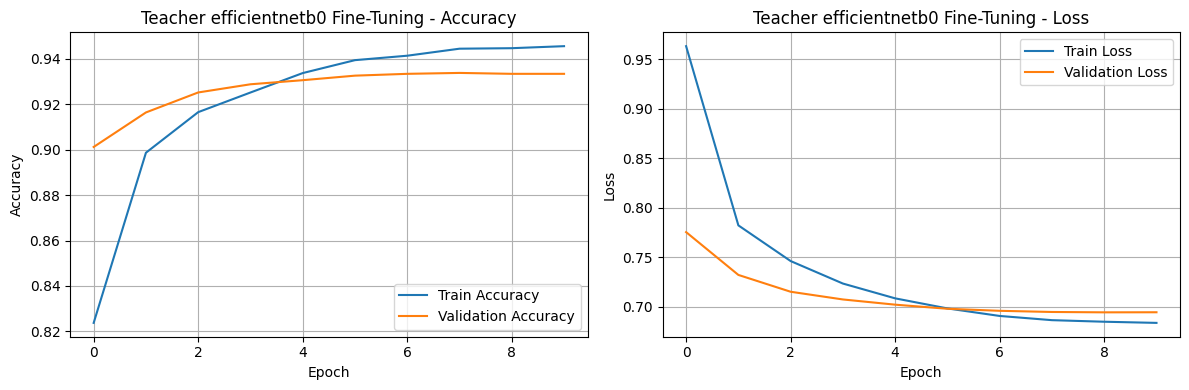

Fine-tuning teacher: mobilenetv2 for 10 epochs ...
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - acc: 0.7165 - loss: 1.1975
Epoch 1: val_acc improved from -inf to 0.55440, saving model to ckpts_sequential_kd/teacher_mobilenetv2_best.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - acc: 0.7170 - loss: 1.1964 - val_acc: 0.5544 - val_loss: 2.9286 - learning_rate: 3.0000e-04
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - acc: 0.8729 - loss: 0.8518
Epoch 2: val_acc did not improve from 0.55440
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 229ms/step - acc: 0.8729 - loss: 0.8518 - val_acc: 0.4080 - val_loss: 4.1805 - learning_rate: 2.9095e-04
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - acc: 0.8962 - loss: 0.7980
Epoch 3: val_acc did not improve from 0.55440
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - acc: 0.8962 - loss: 0.7980 - val_acc: 0.4642 - val_loss: 3.4900 - learning_rate: 2.6491e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - acc: 0.9170 - loss: 0.7

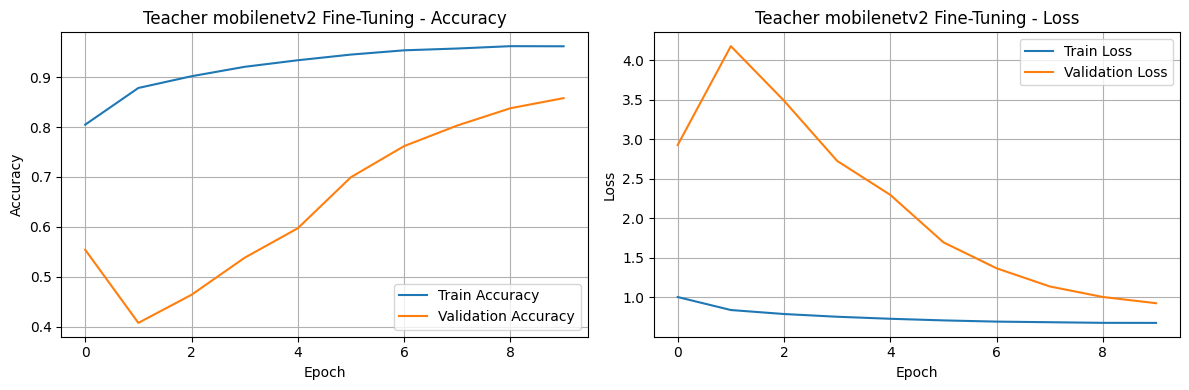

Stage 0: Pre-training student (supervised only, no distillation)
Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - acc: 0.1101 - loss: 6.6125
Epoch 1: val_acc improved from -inf to 0.13340, saving model to ckpts_sequential_kd/student_pretrain_best.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 135s 610ms/step - acc: 0.1101 - loss: 6.6121 - val_acc: 0.1334 - val_loss: 6.3540 - learning_rate: 3.0000e-04
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - acc: 0.1047 - loss: 6.2318
Epoch 2: val_acc did not improve from 0.13340
176/176 ━━━━━━━━━━━━━━━━━━━━ 91s 465ms/step - acc: 0.1047 - loss: 6.2311 - val_acc: 0.1042 - val_loss: 5.4076 - learning_rate: 2.9095e-04
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - acc: 0.0971 - loss: 5.7056
Epoch 3: val_acc did not improve from 0.13340
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 466ms/step - acc: 0.0971 - loss: 5.7049 - val_acc: 0.1092 - val_loss: 4.9699 - learning_rate: 2.6491e-04
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - acc: 0.0957 - 

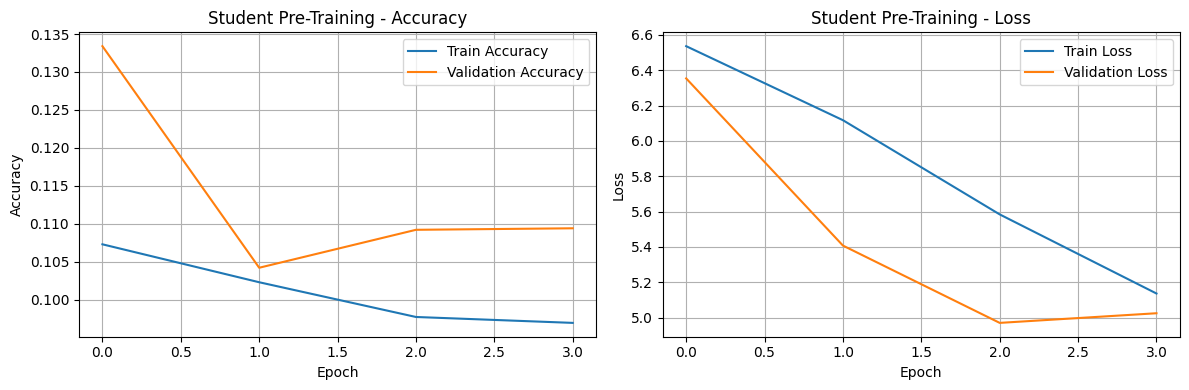

In [12]:
TEACHER1_BACKBONE = "efficientnetb0"   # robust and accurate
TEACHER2_BACKBONE = "mobilenetv2"      # efficient and strong

# Build teachers
teacher1 = build_classifier(TEACHER1_BACKBONE, NUM_CLASSES)
teacher2 = build_classifier(TEACHER2_BACKBONE, NUM_CLASSES)

# Simple function to fine-tune a teacher
def finetune_teacher(model, name, epochs=TEACHER_EPOCHS, unfreeze_top=10):
    # Freeze all, then unfreeze last `unfreeze_top` layers
    for layer in model.layers:
        layer.trainable = False
    # Try to unfreeze top N layers (skip Input & preprocessing)
    for layer in model.layers[-unfreeze_top:]:
        layer.trainable = True

    opt = Adam(BASE_LR)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=LABEL_SMOOTHING),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
    )

    global CURRENT_EPOCHS
    CURRENT_EPOCHS = epochs
    cbs = get_callbacks(name_prefix=f"teacher_{name}", monitor="val_acc", patience=7)

    print(f"Fine-tuning teacher: {name} for {epochs} epochs ...")
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, verbose=1)
    plot_history(history, f"Teacher {name} Fine-Tuning")
    return history

# Fine-tune teacher1 (may take a while)
if TEACHER1_BACKBONE == "efficientnetb0" and EfficientNetB0 is None:
    print("EfficientNetB0 not installed in this environment — skip or change backbone.")
else:
    finetune_teacher(teacher1, TEACHER1_BACKBONE, epochs=TEACHER_EPOCHS, unfreeze_top=10)

# Fine-tune teacher2
finetune_teacher(teacher2, TEACHER2_BACKBONE, epochs=TEACHER_EPOCHS, unfreeze_top=10)

# === Pre-train Student (Supervised for a few epochs) ===
student = small_cnn()

print("Stage 0: Pre-training student (supervised only, no distillation)")
student.compile(
    optimizer=Adam(BASE_LR),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
)

PRETRAIN_EPOCHS = 5
cbs0 = get_callbacks(name_prefix="student_pretrain", monitor="val_acc", patience=3)
history_pretrain = student.fit(train_ds, validation_data=val_ds, epochs=PRETRAIN_EPOCHS, callbacks=cbs0, verbose=1)
plot_history(history_pretrain, "Student Pre-Training")


Stage 1 distillation (teacher1 -> student)
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - acc: 0.1941 - hard_loss: 2.1620 - loss: 2.0616 - soft_loss: 1.9611

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: acc,hard_loss,loss,soft_loss,val_loss,learning_rate
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_acc available.
  if self._should_save_model(epoch, batch, logs, filepath):
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 755ms/step - acc: 0.1940 - hard_loss: 2.1608 - loss: 2.0602 - soft_loss: 1.9596 - val_loss: 2.1247 - learning_rate: 3.0000e-04
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 125s 702ms/step - acc: 0.2946 - hard_loss: 1.9698 - loss: 1.8568 - soft_loss: 1.7438 - val_loss: 1.9749 - learning_rate: 2.9095e-04
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 124s 706ms/step - acc: 0.3263 - hard_loss: 1.9119 - loss: 1.8000 - soft_loss: 1.6881 - val_loss: 1.8468 - learning_rate: 2.6491e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 704ms/step - acc: 0.3506 - hard_loss: 1.8740 - loss: 1.7620 - soft_loss: 1.6500 - val_loss: 1.8331 - learning_rate: 2.2500e-04
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 124s 703ms/step - acc: 0.3624 - hard_loss: 1.8504 - loss: 1.7389 - soft_loss: 1.6275 - val_loss: 1.7929 - learning_rate: 1.7605e-04
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 706ms/step - acc: 0.3804 - hard_loss: 1.8306 - loss: 1.7182 - soft_loss: 1.6059 - val_loss: 1.7752 - learn

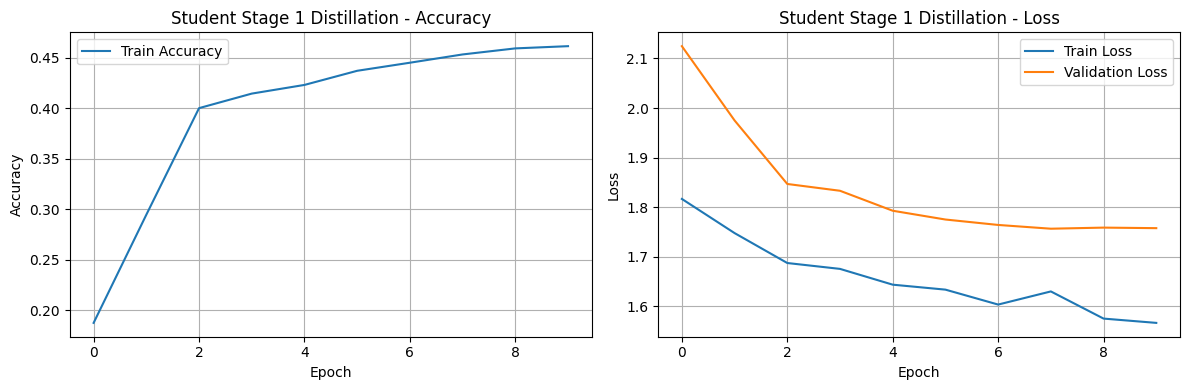

Stage 2 distillation (teacher2 -> student)
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 132s 690ms/step - acc: 0.3611 - hard_loss: 1.8832 - loss: 2.3415 - soft_loss: 2.6471 - val_loss: 1.8482 - learning_rate: 3.0000e-04
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 127s 643ms/step - acc: 0.3697 - hard_loss: 1.8674 - loss: 2.3009 - soft_loss: 2.5898 - val_loss: 1.8599 - learning_rate: 2.9095e-04
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 643ms/step - acc: 0.3787 - hard_loss: 1.8448 - loss: 2.2665 - soft_loss: 2.5477 - val_loss: 1.8427 - learning_rate: 2.6491e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 646ms/step - acc: 0.3928 - hard_loss: 1.8268 - loss: 2.2399 - soft_loss: 2.5152 - val_loss: 1.7669 - learning_rate: 2.2500e-04
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 645ms/step - acc: 0.4001 - hard_loss: 1.8056 - loss: 2.2112 - soft_loss: 2.4817 - val_loss: 1.7422 - learning_rate: 1.7605e-04
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 143s 653ms/step - acc: 0.4068 - hard_loss: 1.7904 - loss:

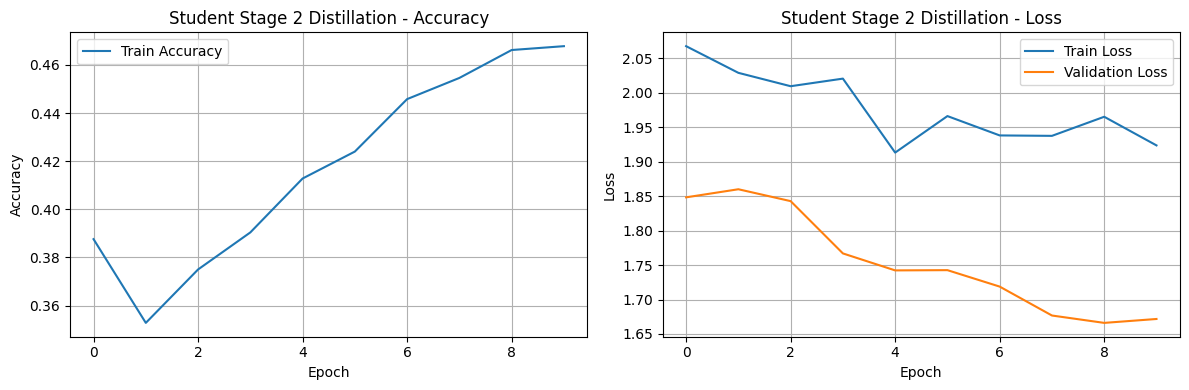

Evaluating teacher1 on test set:
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - acc: 0.9270 - loss: 0.7073
Evaluating teacher2 on test set:
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - acc: 0.8537 - loss: 0.9427
Evaluating final student on test set:
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - acc: 0.4598 - loss: 1.6593
Test results (student): [<tf.Tensor: shape=(), dtype=float32, numpy=1.6020286083221436>, {'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.4610000252723694>}]
Final student saved at: ckpts_sequential_kd/student_final.keras


In [13]:

student.save(os.path.join(CKPT_DIR, "student_after_pretrain.keras"))

# === Stage 1: distill from teacher1 -> student ===
distiller_1 = Distiller(student=student, teacher=teacher1, temperature=4.0, alpha=0.5, label_smoothing=LABEL_SMOOTHING)
opt_student = Adam(BASE_LR)
distiller_1.compile(optimizer=opt_student, metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")])

CURRENT_EPOCHS = STUDENT_STAGE1_EPOCHS
cbs = get_callbacks(name_prefix="student_stage1", monitor="val_acc", patience=7)
print("Stage 1 distillation (teacher1 -> student)")
history_stage1 = distiller_1.fit(train_ds, validation_data=val_ds, epochs=STUDENT_STAGE1_EPOCHS, callbacks=cbs, verbose=1)
plot_history(history_stage1, "Student Stage 1 Distillation")

# Save intermediate student
student.save(os.path.join(CKPT_DIR, "student_after_stage1.keras"))

# === Stage 2: distill from teacher2 -> same student (continues training) ===
opt_student_stage2 = Adam(BASE_LR * 0.5)
distiller_2 = Distiller(student=student, teacher=teacher2, temperature=4.0, alpha=0.4, label_smoothing=LABEL_SMOOTHING)
distiller_2.compile(optimizer=opt_student_stage2, metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")])

CURRENT_EPOCHS = STUDENT_STAGE2_EPOCHS
cbs2 = get_callbacks(name_prefix="student_stage2", monitor="val_acc", patience=6)
print("Stage 2 distillation (teacher2 -> student)")
history_stage2 = distiller_2.fit(train_ds, validation_data=val_ds, epochs=STUDENT_STAGE2_EPOCHS, callbacks=cbs2, verbose=1)
plot_history(history_stage2, "Student Stage 2 Distillation")

# === Final Evaluation ===
print("Evaluating teacher1 on test set:")
teacher1.evaluate(test_ds, verbose=1)

print("Evaluating teacher2 on test set:")
teacher2.evaluate(test_ds, verbose=1)

print("Evaluating final student on test set:")
eval_results = distiller_2.evaluate(test_ds, verbose=1)
print("Test results (student):", eval_results)

# Save final student
student.save(os.path.join(CKPT_DIR, "student_final.keras"))
print("Final student saved at:", os.path.join(CKPT_DIR, "student_final.keras"))